In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from sqlalchemy import create_engine
import pandas as pd

# 1. Load environment variables from .env
load_dotenv(r"C:\Users\msaad\Desktop\customer-churn-prediction-main\credentials.env")   # <-- absolute path to your .env

# 2. Read them into Python variables (no stray commas!)
host     = os.getenv("DB_HOST", "127.0.0.1")
user     = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
database = os.getenv("DB_NAME")

# 3. Create the SQLAlchemy engine
engine = create_engine(
    f"mysql+mysqlconnector://{user}:{password}@{host}/{database}"
)

# 4. Read your CSV
csv_path = r"C:\Users\msaad\Desktop\customer-churn-prediction-main\Telco-Customer-Churn.csv"
df = pd.read_csv(csv_path)

# 5. Upload to MySQL (this will CREATE the table if it doesn’t exist)
df.to_sql(
    name='customers',
    con=engine,
    if_exists='replace',  # or 'append' if you just want to add rows
    index=False
)
print("CSV uploaded successfully!")

# 6. (Optional) Query the table back to verify
with engine.connect() as conn:
    preview = pd.read_sql("SELECT * FROM customers LIMIT 5;", conn)
print(preview)
print(preview.dtypes)


CSV uploaded successfully!
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV Streaming

In [2]:
# Create a separate copy for modeling
df_model = df.drop(columns=["customerID"])
df_model = pd.get_dummies(df_model, drop_first=True)

# Convert any boolean to int 
bool_cols = df_model.select_dtypes(include='bool').columns
df_model[bool_cols] = df_model[bool_cols].astype(int)

In [3]:
# Convert 'TotalCharges' to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check if there are other columns that need conversion
# Assuming 'MonthlyCharges' might also be a column needing conversion
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors='coerce')


In [4]:
# Fill NaN values with the median of each column
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    df[column] = df[column].fillna(df[column].median())

In [5]:
print("Remaining NaN counts in each column:")
print(df.isna().sum())

Remaining NaN counts in each column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [6]:
# Convert Yes/No to 0/1
yes_no_cols = ["Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"]
for col in yes_no_cols:
    df[col] = df[col].map({"Yes": 1, "No": 0})

# Keep original df for Power BI use
df_visual = df.copy()

In [7]:
# One-hot encode all categorical columns (like gender, contract, etc.)
df_encoded = pd.get_dummies(df, drop_first=True)

# Check the new shape and preview
print("Encoded shape:", df_encoded.shape)
df_encoded.head()

Encoded shape: (7043, 7073)


,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,customerID_0003-MKNFE,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,1,29.85,29.85,0,False,...,False,False,False,False,False,False,False,False,True,False
1,0,0,0,34,1,0,56.95,1889.50,0,False,...,False,False,False,False,False,True,False,False,False,True
2,0,0,0,2,1,1,53.85,108.15,1,False,...,False,False,False,False,False,False,False,False,False,True
3,0,0,0,45,0,0,42.30,1840.75,0,False,...,True,False,False,False,False,True,False,False,False,False
4,0,0,0,2,1,1,70.70,151.65,1,False,...,False,False,False,False,False,False,False,False,True,False


In [8]:
# Define the target column
y = df_encoded["Churn_Yes"] if "Churn_Yes" in df_encoded.columns else df_encoded["Churn"]

# Define features by dropping the target column
X = df_encoded.drop(columns=["Churn", "Churn_Yes"], errors='ignore')

In [9]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling      int64
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

In [10]:
# Drop columns not useful for model
df_model = df.drop(columns=["customerID"])

# One-hot encode all categorical columns for model
df_model = pd.get_dummies(df_model, drop_first=True)

# Ensure all booleans are converted to integers
bool_cols = df_model.select_dtypes(include='bool').columns
df_model[bool_cols] = df_model[bool_cols].astype(int)

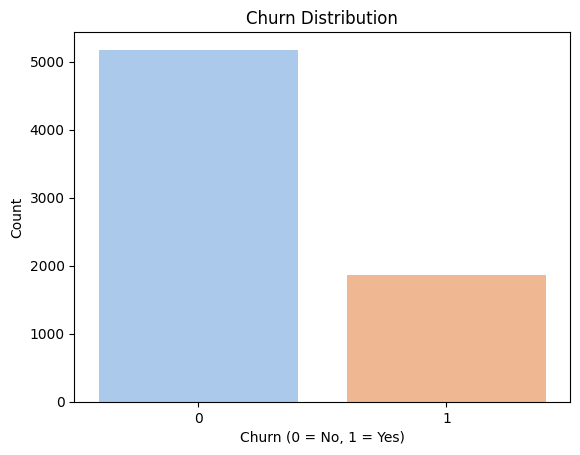

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(
    x="Churn",
    hue="Churn",         # ← assign x to hue
    data=df,
    palette="pastel",
    legend=False         # ← hide the legend Seaborn adds for hue
)
plt.title("Churn Distribution")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

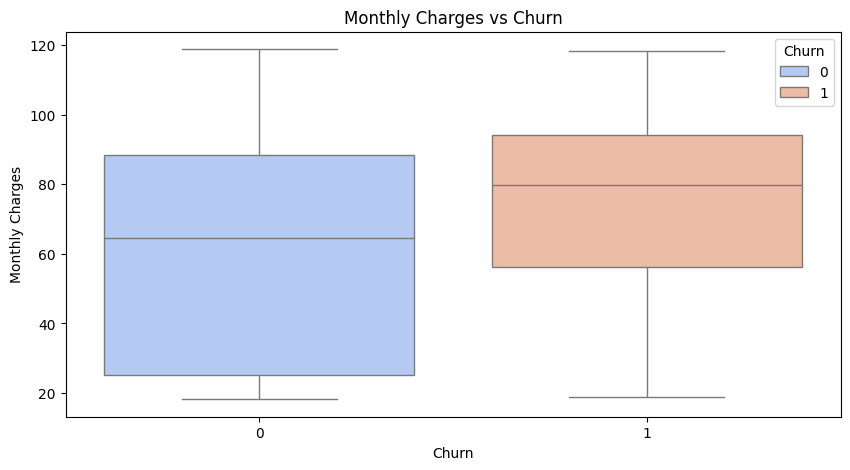

In [13]:
# Temporarily add the target back to X for plotting
X_plot = X.copy()
X_plot["Churn"] = y  # y is already your 0/1 target

# Plot using X_plot
plt.figure(figsize=(10, 5))
sns.boxplot(x="Churn", y="MonthlyCharges", hue="Churn", data=X_plot, palette="coolwarm", dodge=False)
plt.title("Monthly Charges vs Churn")
plt.xlabel("Churn")
plt.ylabel("Monthly Charges")
plt.show()

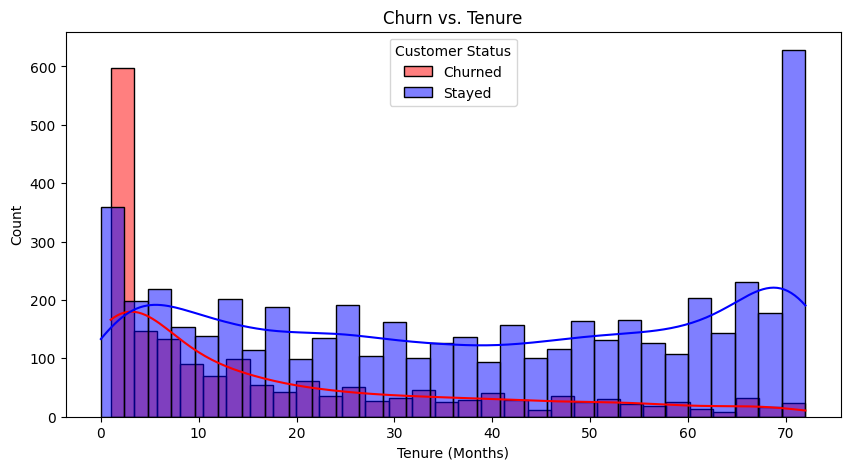

In [17]:
# Set the size of the plot
plt.figure(figsize=(10, 5))

# Plotting two categories with different colors and labels
sns.histplot(data=df[df['Churn'] == 1], x='tenure', bins=30, color='red', label='Churned', kde=True)
sns.histplot(data=df[df['Churn'] == 0], x='tenure', bins=30, color='blue', label='Stayed', kde=True)

# Adding labels and title
plt.xlabel('Tenure (Months)')
plt.ylabel('Count')
plt.title('Churn vs. Tenure')

# Adding the legend explicitly
plt.legend(title='Customer Status')  # Ensure this is after all plots

# Show the plot
plt.show()

In [15]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (5634, 7072)
Test shape: (1409, 7072)


In [16]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Apply SMOTE only to training data
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_resampled.value_counts())

model = RandomForestClassifier(random_state=42)

# Now train the model on the balanced data
model.fit(X_resampled, y_resampled)

Before SMOTE: Churn
0    4138
1    1496
Name: count, dtype: int64
After SMOTE: Churn
0    4138
1    4138
Name: count, dtype: int64


RandomForestClassifier(random_state=42)

In [18]:
# Create a Series of feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)

# Sort them from most to least important
importances = importances.sort_values(ascending=False)

# View top 10 features
print(importances.head(10))

TotalCharges                      0.089775
tenure                            0.084101
PaymentMethod_Electronic check    0.068421
MonthlyCharges                    0.066691
InternetService_Fiber optic       0.038852
Contract_Two year                 0.028446
Dependents                        0.026214
Partner                           0.023837
Contract_One year                 0.015337
gender_Male                       0.014520
dtype: float64


In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on test set
y_pred = model.predict(X_test)

# Print results
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.794889992902768

Confusion Matrix:
 [[903 133]
 [156 217]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      1036
           1       0.62      0.58      0.60       373

    accuracy                           0.79      1409
   macro avg       0.74      0.73      0.73      1409
weighted avg       0.79      0.79      0.79      1409



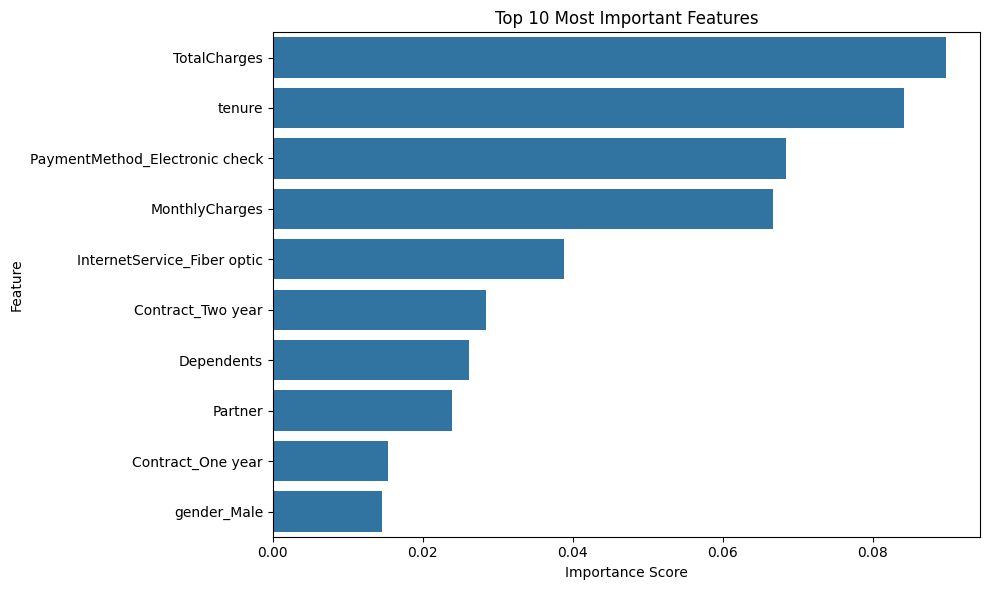

In [20]:
# Plot top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values[:10], y=importances.index[:10])
plt.title("Top 10 Most Important Features")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [21]:
print(importances.sort_values())

customerID_4195-SMMNX             0.000000
customerID_9933-QRGTX             0.000000
customerID_4226-KKDON             0.000000
customerID_4213-HKBJO             0.000000
customerID_3256-EZDBI             0.000000
                                    ...   
InternetService_Fiber optic       0.038852
MonthlyCharges                    0.066691
PaymentMethod_Electronic check    0.068421
tenure                            0.084101
TotalCharges                      0.089775
Length: 7072, dtype: float64


In [22]:
df.to_csv("cleaned_churn_data.csv", index=False)

In [23]:
# Export both cleaned versions
df_model.to_csv("ml_ready_data.csv", index=False)
df_visual.to_csv("powerbi_ready_data.csv", index=False)